In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

In [5]:
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

In [5]:
# 1. Data Loading and Preprocessing

In [6]:
try:
    df = pd.read_csv('/content/sample_data/eu_sdg_performance_data.csv')
except FileNotFoundError:
    print("Error: File 'eu_sdg_performance_data.csv' not found.")
    exit()

In [7]:
df_latest = df[df['year'] == 2022].copy()
numerical_cols = [
    'sdg8_income', 'sdg8_unemp', 'sdg8_inwork', 'sdg9_eurd', 'sdg9_digital',
    'sdg9_bband', 'sdg16_cpi', 'sdg16_rsf', 'sdg16_crime', 'sdg4_tertiary',
    'sdg4_adult', 'sdg7_eurenew', 'sdg13_co2gcp', 'sdg5_empgap', 'sdg10_gini'
]

In [8]:
df_clustering = df_latest[['Country'] + numerical_cols].set_index('Country')

In [9]:
print(f"Initial number of rows: {len(df_clustering)}")
df_clustering = df_clustering.fillna(df_clustering.median())
print(f"Number of rows after median imputation: {len(df_clustering)}")

Initial number of rows: 42
Number of rows after median imputation: 42


In [11]:
# 2. Data Standardization

In [10]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(data_scaled, columns=df_clustering.columns, index=df_clustering.index)

In [12]:
# 3. Elbow Method to determine optimal K

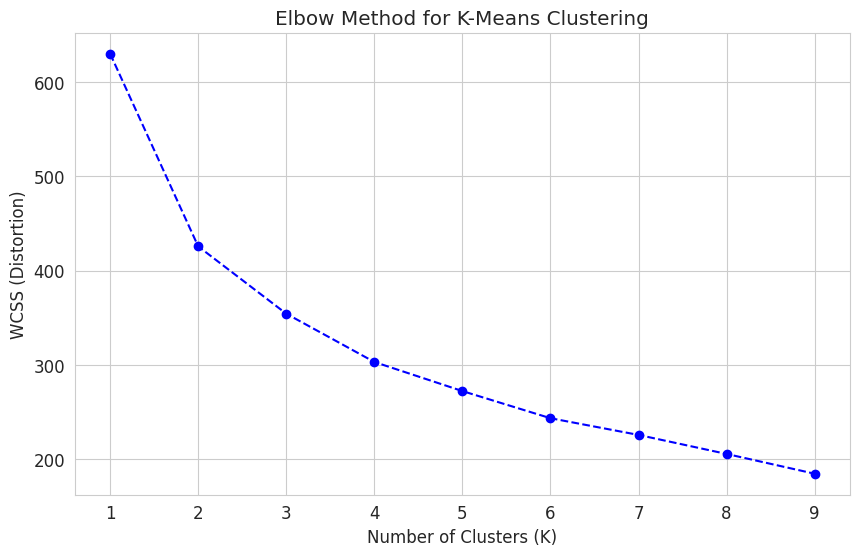

In [13]:
distortions = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300, tol=0.0001, algorithm='lloyd')
    kmeans.fit(df_scaled)
    distortions.append(kmeans.inertia_) # inertia_ - is WCSS

plt.figure(figsize=(10, 6))
plt.plot(K_range, distortions, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method for K-Means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Distortion)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [14]:
# 4. Perform K-Means Clustering

In [16]:
optimal_k = 3

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, algorithm='lloyd')
df_scaled['Cluster'] = kmeans_final.fit_predict(df_scaled)

In [17]:
# 5. Cluster Visualization (using PCA)

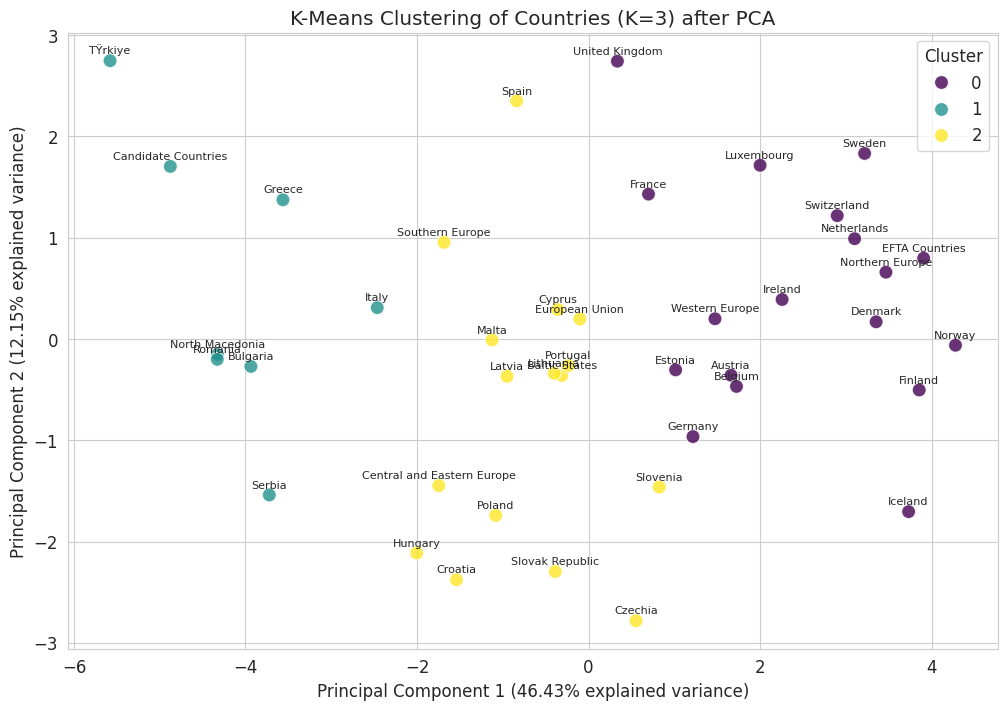

In [18]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled.drop('Cluster', axis=1))
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=df_scaled.index)
pca_df['Cluster'] = df_scaled['Cluster']

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='PC1', y='PC2', hue='Cluster', palette='viridis',
    data=pca_df, s=100, alpha=0.8
)

for i, row in pca_df.iterrows():
    plt.annotate(
        i, (row['PC1'], row['PC2']),
        textcoords="offset points", xytext=(0, 5),
        ha='center', fontsize=8
    )

plt.title(f'K-Means Clustering of Countries (K={optimal_k}) after PCA')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
plt.legend(title='Cluster')
plt.show()

In [19]:
# 6. Cluster Profile Analysis (Mean Feature Values)

In [20]:
df_clustering['Cluster'] = df_scaled['Cluster']

cluster_profiles = df_clustering.groupby('Cluster')[numerical_cols].mean().T
cluster_profiles.columns = [f'Cluster {i} (Count: {count})' for i, count in df_clustering['Cluster'].value_counts().sort_index().items()]

print("Mean feature values by cluster (unscaled data):")
print(cluster_profiles.to_string(float_format="%.2f"))

Mean feature values by cluster (unscaled data):
               Cluster 0 (Count: 18)  Cluster 1 (Count: 8)  Cluster 2 (Count: 16)
sdg8_income                 28454.78              18319.25               21422.94
sdg8_unemp                      5.22                  9.88                   5.88
sdg8_inwork                     7.11                 10.88                   8.00
sdg9_eurd                       2.56                  0.75                   1.25
sdg9_digital                   67.28                 36.75                  53.25
sdg9_bband                     95.72                 88.25                  91.25
sdg16_cpi                      78.94                 43.12                  56.06
sdg16_rsf                      84.00                 58.88                  73.69
sdg16_crime                    10.06                 11.12                   6.94
sdg4_tertiary                  49.44                 35.50                  43.69
sdg4_adult                     20.17              

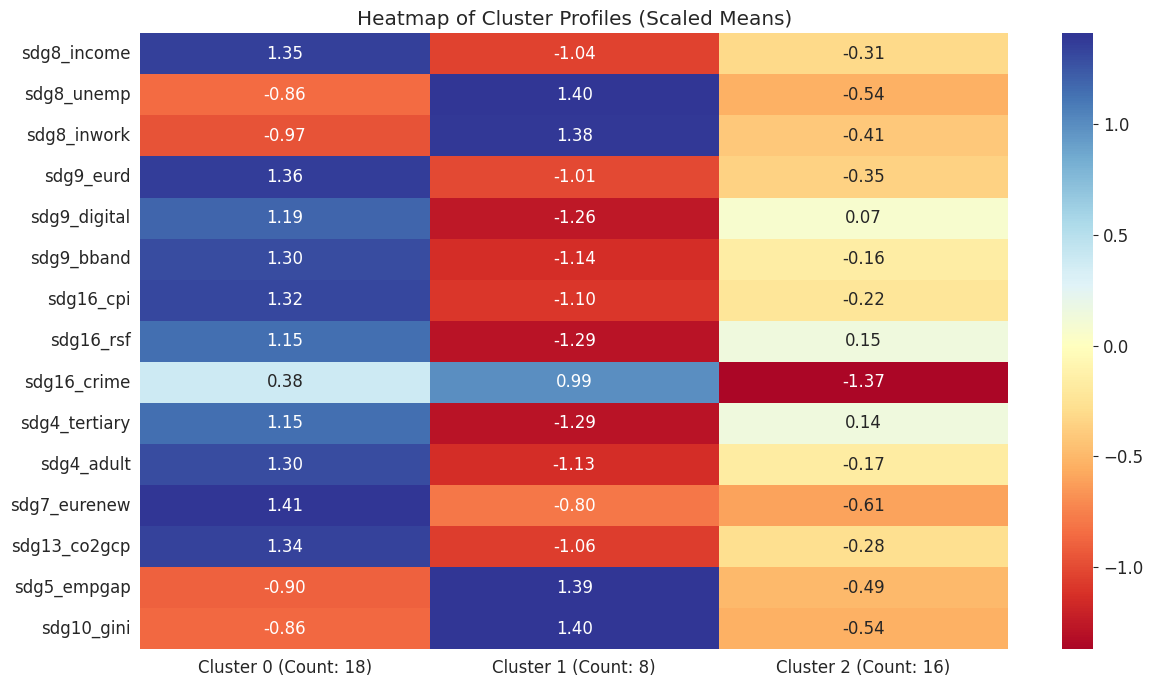


--- List of Countries in Each Cluster ---

Cluster 0 (18 countries):
Austria, Belgium, Denmark, EFTA Countries, Estonia, Finland, France, Germany, Iceland, Ireland, Luxembourg, Netherlands, Northern Europe, Norway, Sweden, Switzerland, United Kingdom, Western Europe

Cluster 1 (8 countries):
Bulgaria, Candidate Countries, Greece, Italy, North Macedonia, Romania, Serbia, TŸrkiye

Cluster 2 (16 countries):
Baltic States, Central and Eastern Europe, Croatia, Cyprus, Czechia, European Union, Hungary, Latvia, Lithuania, Malta, Poland, Portugal, Slovak Republic, Slovenia, Southern Europe, Spain


In [21]:
plt.figure(figsize=(14, 8))
sns.heatmap(
    scaler.fit_transform(cluster_profiles.T).T,
    annot=True, fmt=".2f", cmap="RdYlBu", center=0,
    yticklabels=cluster_profiles.index,
    xticklabels=cluster_profiles.columns
)
plt.title('Heatmap of Cluster Profiles (Scaled Means)')
plt.show()

print("\n--- List of Countries in Each Cluster ---")
for i in range(optimal_k):
    countries = df_clustering[df_clustering['Cluster'] == i].index.tolist()
    print(f"\nCluster {i} ({len(countries)} countries):\n{', '.join(countries)}")